In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, hamming_loss, classification_report
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
import json
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor

# Sample a balanced Dataset for exploration

## Load and prepare main dataset

In [2]:
main_dataset = pd.read_parquet('GenericMixOfTopic.parquet')
# main_dataset = pd.read_parquet('sampled_data.parquet')

main_dataset['topics_with_percentages'] = main_dataset['topics_with_percentages'].apply(lambda x: json.loads(x))

## Distribution of Labels exploration

define functions to extract labels and plot the distribution

In [3]:
def extract_labels(df, max_labels = 3, min_percentage = 0.1):
    labels_df = pd.DataFrame(df['topics_with_percentages'].to_list())
    
    # all elements below min_percentage must turn into 0
    labels_df = labels_df.applymap(lambda x: None if x < min_percentage else x)

    # Extract max_labels greatest values in each row
    labels_df = labels_df.apply(lambda x: x.nlargest(max_labels), axis=1)

    # all non None elements to 1
    labels_df = labels_df.applymap(lambda x: 0 if pd.isnull(x) else 1)

    return labels_df
    
def plot_labels_distribution(labels_df):
    label_dist = labels_df.sum()
    label_dist.sort_values(ascending=False, inplace=True)

    # bar chart for the number of instances of each label
    plt.figure(figsize=(10, 6))
    label_dist.plot(kind='bar')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.title('Number of Instances of Each Label')
    plt.show()

def get_labels_distribution(labels_df):
    label_dist = labels_df.sum()
    label_dist.sort_values(ascending=False, inplace=True)
    return label_dist

Extract labels of each row and save them to labels_df

In [5]:
# labels_df = extract_labels(main_dataset)
# labels_df = pd.read_csv('labels_df_maxLabels-3_minPercentage-0.1.csv', index_col=0)
labels_df = extract_labels(main_dataset, min_percentage=0.12)

# concat the labels to the main dataset
main_dataset = pd.concat([main_dataset, labels_df], axis=1)

main_dataset.shape

(200005, 44)

In [9]:
single_topics = main_dataset[main_dataset["topic"] != "Mixed"]

# count for each row, how many ones there are between columns Academic_disciplines to Universe
single_topics["num_topics"] = single_topics.iloc[:, 7:].sum(axis=1)

              id                             title        topic                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      topics_with_percentages                                                                                                                                                                                                                                                                                                                            

C:\Users\BlackDEATH\AppData\Local\Temp\ipykernel_3324\402842230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['topic-percentage'] = temp.apply(lambda x: x['topics_with_percentages'].get(x['topic']), axis=1)


In [13]:
single_topics.iloc[:, 5:-1].sum(axis=1).sort_values(ascending=False)

4         1
133114    1
133185    1
133175    1
133172    1
         ..
66447     1
66433     1
66431     1
66419     1
200002    1
Length: 30005, dtype: int64

In [14]:
main_dataset.to_pickle('main_dataset_correctedSingleTopics.pkl')

Plot the labels' distribution with a max number of labels allowed as 3 and a threshold of 0.1 probability

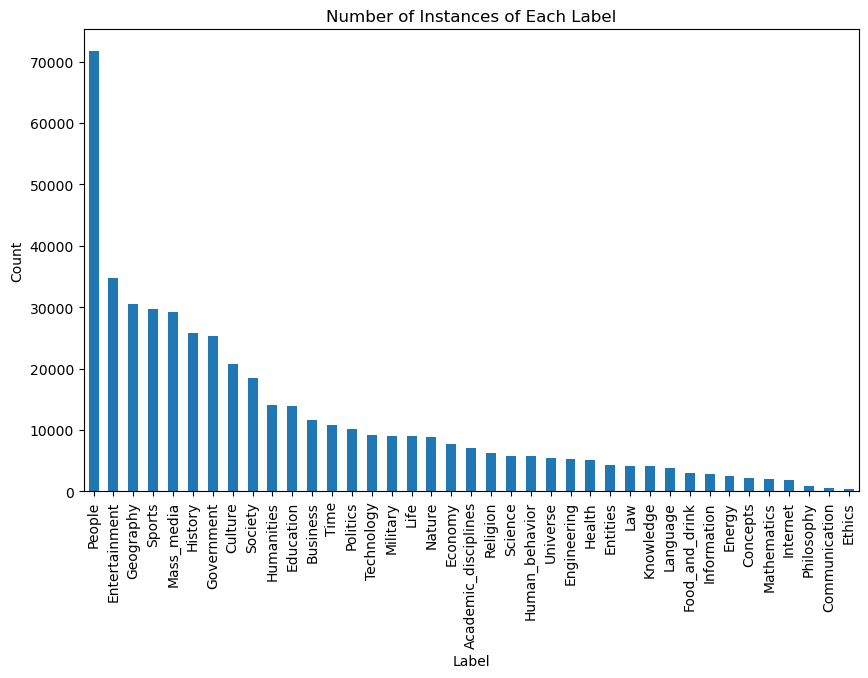

In [5]:
plot_labels_distribution(labels_df)

In [6]:
get_labels_distribution(labels_df)

People                  71654
Entertainment           34765
Geography               30514
Sports                  29766
Mass_media              29252
History                 25793
Government              25328
Culture                 20777
Society                 18519
Humanities              14094
Education               13928
Business                11654
Time                    10888
Politics                10220
Technology               9190
Military                 9115
Life                     9041
Nature                   8827
Economy                  7689
Academic_disciplines     7014
Religion                 6323
Science                  5797
Human_behavior           5735
Universe                 5412
Engineering              5272
Health                   5134
Entities                 4361
Law                      4205
Knowledge                4157
Language                 3868
Food_and_drink           3052
Information              2768
Energy                   2449
Concepts  

Plot the number of labels histogram

In [7]:
def plot_label_count_distribution(labels_df):
    label_count = labels_df.sum(axis=1)

    # bar chart for the number of instances with each number of labels
    plt.figure(figsize=(10, 6))
    label_count.value_counts().sort_index().plot(kind='bar')
    plt.xlabel('Number of Labels')
    plt.ylabel('Count')
    plt.title('Number of Instances with Each Number of Labels')
    plt.show()

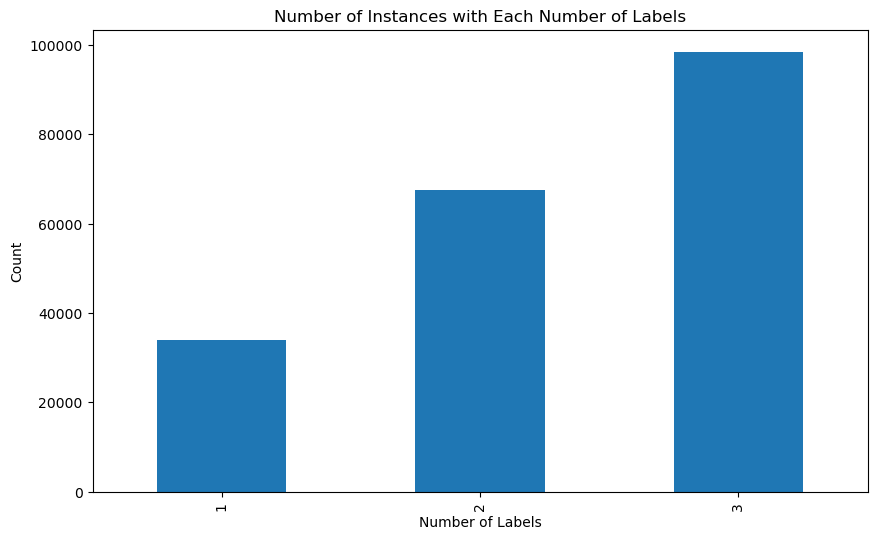

In [8]:
plot_label_count_distribution(labels_df)

## Sampling a representative dataset

a representative sample, in this context must have:
- Balanced distribution of labels count
- Balanced Ditribution of label distribution

Inorder to create this sample, we need to have a method of balanced sampling to each group of labels count

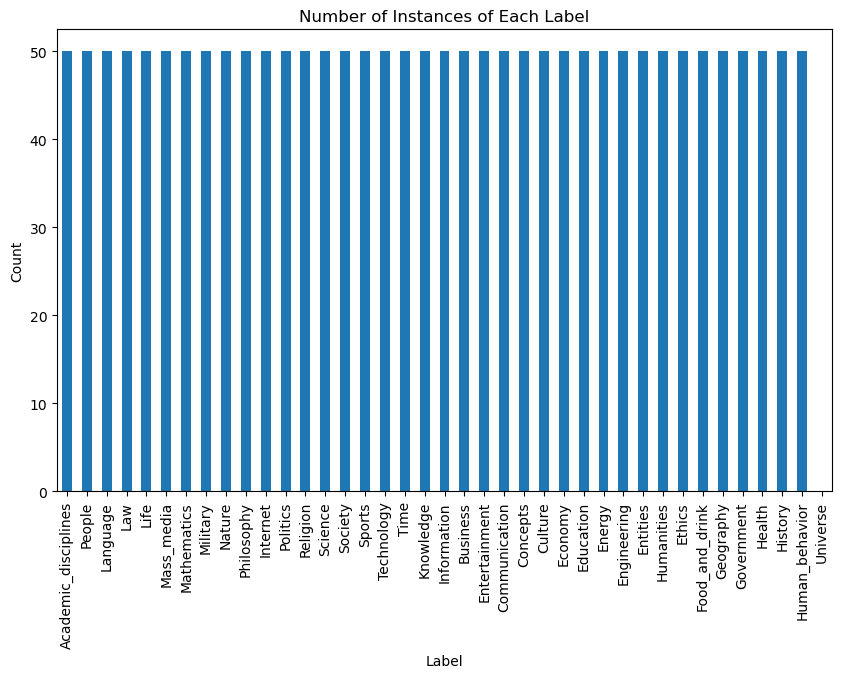

In [13]:
# new column with the number of labels
labels_count = labels_df.sum(axis=1)

sample_gp1 = labels_df[labels_count == 1]
sample_gp2 = labels_df[labels_count == 2]
sample_gp3 = labels_df[labels_count == 3]

# for each label, sample 50 rows that have a value of 1 for that label, concatenate the rows
sample_gp1 = pd.concat([sample_gp1[sample_gp1[col] == 1].sample(50, random_state=1) for col in sample_gp1.columns[:-1]])

plot_labels_distribution(sample_gp1)

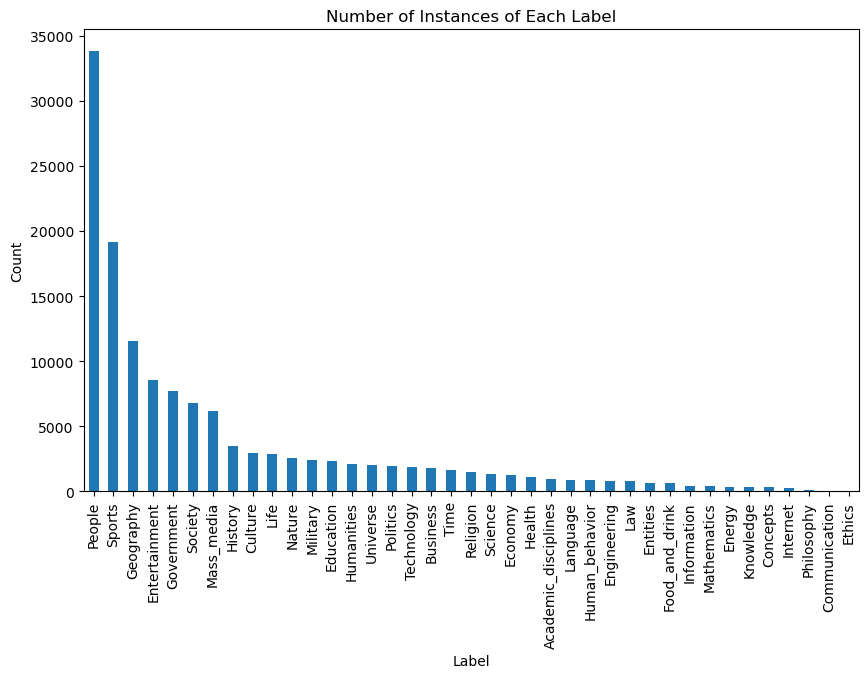

In [31]:
sample_gp2 = labels_df[labels_count == 2]
plot_labels_distribution(sample_gp2)

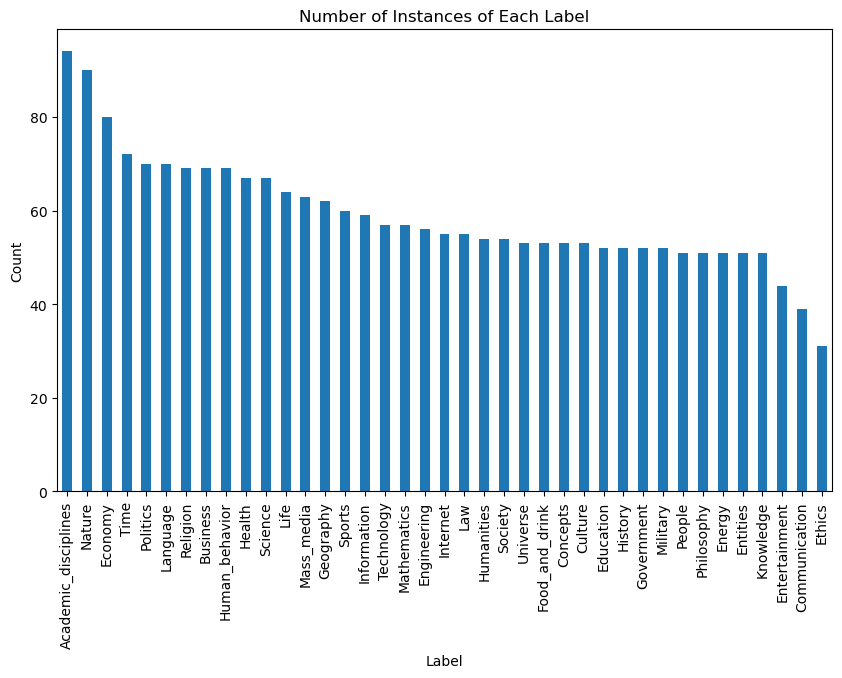

In [40]:
sample_gp2 = labels_df[labels_count == 2]

# get list of columns
columns = sample_gp2.sum()
columns.sort_values(ascending=False, inplace=True)
columns = columns.index

# create a empty dataframe like sample_gp2
sample = pd.DataFrame(columns=sample_gp2.columns)

for col in columns[::-1]:

    temp_sum = sample.sum()

    # find indexes of temp_sum with values greter than 50
    indexes = temp_sum[temp_sum > 50].index

    # if col is in indexes, skip the column
    if col in indexes:
        continue

    # select rows with value 1 in col
    selected_rows = sample_gp2[sample_gp2[col] == 1]

    for row in indexes:
        # select rows with value 0 in row
        selected_rows = selected_rows[selected_rows[row] == 0]

    if selected_rows.shape[0] > 50:
        selected_rows = selected_rows.sample(50, random_state=1)
        # concat selected rows with sample
        sample = pd.concat([sample, selected_rows])
    else:
        sample = pd.concat([sample, selected_rows])

plot_labels_distribution(sample)

sample_gp2 = sample

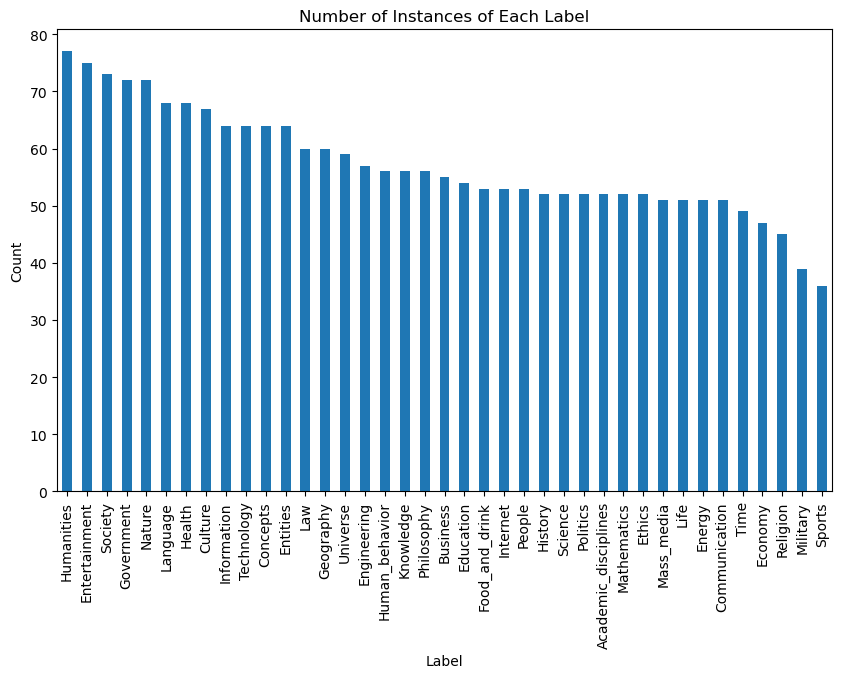

In [42]:
sample_gp3 = labels_df[labels_count == 3]

# get list of columns
columns = sample_gp3.sum()
columns.sort_values(ascending=False, inplace=True)
columns = columns.index

# create a empty dataframe like sample_gp2
sample = pd.DataFrame(columns=sample_gp3.columns)

for col in columns[::-1]:

    temp_sum = sample.sum()

    # find indexes of temp_sum with values greter than 50
    indexes = temp_sum[temp_sum > 50].index

    # if col is in indexes, skip the column
    if col in indexes:
        continue

    # select rows with value 1 in col
    selected_rows = sample_gp3[sample_gp3[col] == 1]

    for row in indexes:
        # select rows with value 0 in row
        selected_rows = selected_rows[selected_rows[row] == 0]

    if selected_rows.shape[0] > 50:
        selected_rows = selected_rows.sample(50, random_state=1)
        # concat selected rows with sample
        sample = pd.concat([sample, selected_rows])
    else:
        sample = pd.concat([sample, selected_rows])

plot_labels_distribution(sample)

sample_gp3 = sample

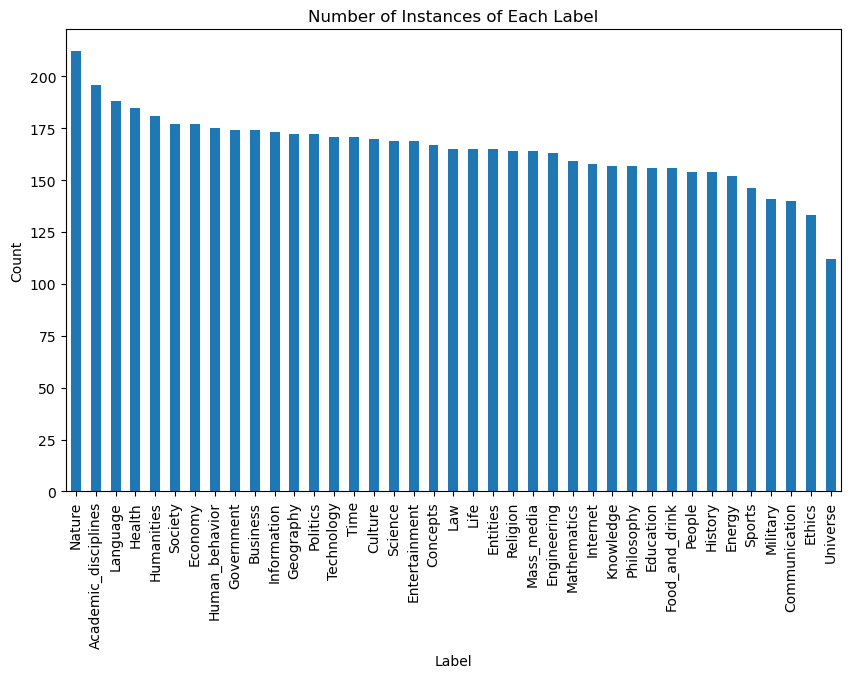

In [43]:
# concatenate the samples
sample = pd.concat([sample_gp1, sample_gp2, sample_gp3])

plot_labels_distribution(sample)

In [46]:
# use indexes of sample to get the rows from main_dataset
sampled_dataset = main_dataset.loc[sample.index]

# save the sampled dataset
sampled_dataset.to_parquet('sampled_data_balanced_heuristic.parquet')

,Academic_disciplines,Business,Communication,Concepts,Culture,Economy,Education,Energy,Engineering,Entertainment,...,People,Philosophy,Politics,Religion,Science,Society,Sports,Technology,Time,Universe
140774,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
112949,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
171292,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44220,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
175466,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196464,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
110315,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
119505,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
122062,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
